# Exploring and Cleaning the Data

This notebook goes through the steps used to begin exploring clean the raw data obtained. Before we can clean the data, it is important to understand the overall properties of the data. This can help identify data that is important to our goals and data that is unnecessary for training our desired model. Cleaning makes sure the tweets are in the best format for analysis and training a model for sentiment analysis.

__Columns__
- `target` sentiment of tweet (0=positive, 4=negative)
- `id` unique identifier of tweet
- `date` date and time of tweet
- `flag` the query if one exists
- `user` user that authored the tweet
- `text` text content of the tweet, emoticons are removed

This data is publicly available on [Kaggle](https://www.kaggle.com/kazanova/sentiment140) and was created by the authors of the publication:

    Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

_Note: 
This notebook expects the zipped dataset to be in the `./resources` sub-directory with the name `raw_twitter_data.zip`
(e.g., `./resources/raw_twitter_data.zip`). If the dataset does not exist it will be downloaded and saved in this location._

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tokenization
!{sys.executable} -m pip install wordcloud

In [2]:
import os
import string
from urllib.request import urlopen, Request

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import tokenization

from wordcloud import STOPWORDS

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Read File
Read the file into memory to determine its overall shape. If the file does not exist locally it is downloaded into the `./resources` directory.

In [3]:
file_name = 'raw_twitter_data.zip'
resources_dir = 'resources'
file_path = './{}/{}'.format(resources_dir, file_name)
is_file_downloaded = os.path.exists(file_path)

In [4]:
if not is_file_downloaded:
    if not os.path.exists(resources_dir):
        os.makedirs(resources_dir)
    
    file_url = 'https://dorman-public-data.s3-us-west-2.amazonaws.com/' + file_name
    req = Request(file_url)
    
    with open(file_path, 'wb') as target:
        target.write(urlopen(req).read())

In [5]:
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']

df = pd.read_csv(file_path, encoding = 'ISO-8859-1', names=col_names, compression='zip')
df = df.dropna(how="any", axis=1)

In [6]:
def df_summary(data_frame):
    BYTES_IN_MB = 1024**2
    print('Columns: {}'.format(data_frame.columns))
    print('Shape: {}'.format(data_frame.shape))
    print('Memory Usage:{:.4f} Mb'.format(data_frame.memory_usage().sum() / BYTES_IN_MB))

In [7]:
df_summary(df)

Columns: Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')
Shape: (1600000, 6)
Memory Usage:73.2423 Mb


In [8]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Remove Extra Columns
The only columns of real interest to train a model for tweet sentiment classification is the `target` and `text` columns. The `target` column indicates the sentiment of the tweet and `text` contains the text of the tweet.

In [9]:
df.drop(['id', 'date', 'flag', 'user'], axis='columns', inplace=True)
df_summary(df)

Columns: Index(['target', 'text'], dtype='object')
Shape: (1600000, 2)
Memory Usage:24.4142 Mb


## Exploratory Analysis
Examining the data for differences in data points associated with different sentiments can help us understand if our data is balanced across our target categories. Additionally, it can helps use understand if we should direct the focus of our training on to or away from any data characteristics to get the best possible sentiment classification model.

### Meta Features

In [10]:
df['num_words'] = df['text'].apply(lambda s: len(s.split(' ')))
df['num_unique_words'] = df['text'].apply(lambda s: len(set(s.split(' '))))
df['num_stop_words'] = df['text'].apply(lambda s: len([w for w in s.lower().split(' ') if w in STOPWORDS]))
df['avg_word_length'] = df['text'].apply(lambda s: np.mean([len(w) for w in s.split(' ')]))
df['num_chars'] = df['text'].apply(lambda s: len(s))
df['num_punctuation'] = df['text'].apply(lambda s: len([c for c in s if c in string.punctuation]))
df['num_urls'] = df['text'].apply(lambda s: len([w for w in s.lower().split() if 'http' in w or 'https' in w]))
df['num_hashtags'] = df['text'].apply(lambda s: len([c for c in s if c == '#']))
df['num_mentions'] = df['text'].apply(lambda s: len([c for c in s if c == '@']))

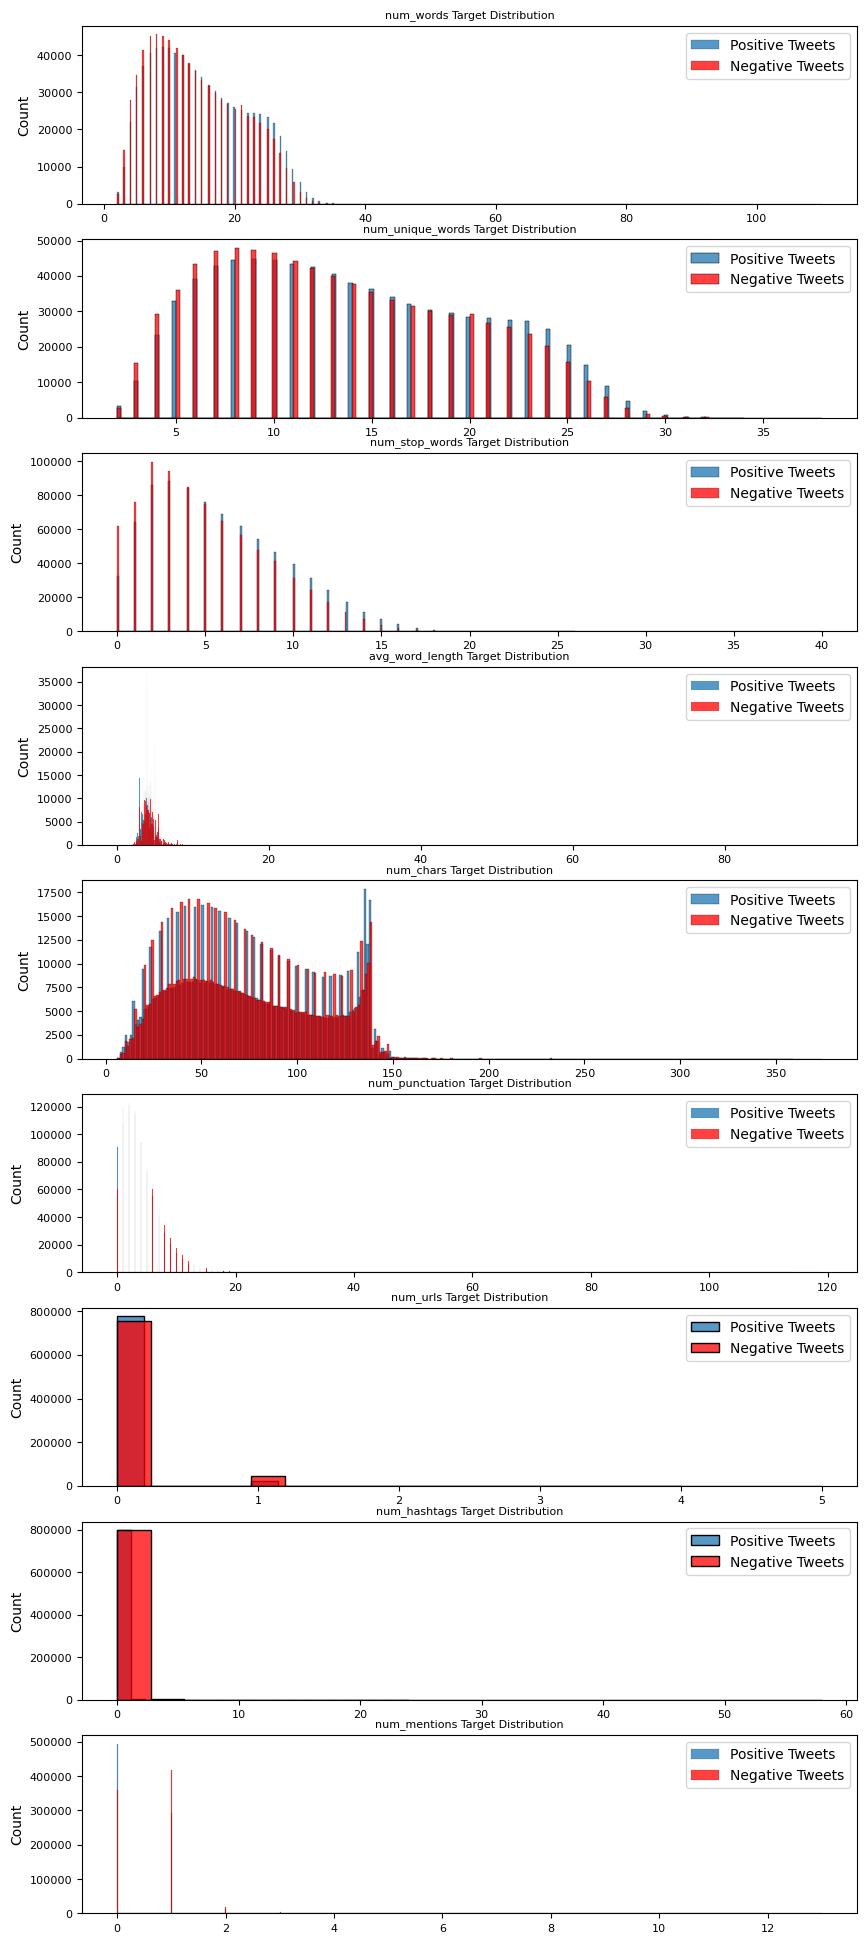

In [29]:
meta_feature_cols = ['num_words', 'num_unique_words', 'num_stop_words', 'avg_word_length', 
                     'num_chars', 'num_punctuation', 'num_urls', 'num_hashtags', 'num_mentions']
positive_tweets = df['target'] == 0

figure, axes = plt.subplots(ncols=1, nrows=len(meta_feature_cols), figsize=(10,25), dpi=100)

for i, meta_feature in enumerate(meta_feature_cols):
    sns.histplot(df.loc[positive_tweets][meta_feature], label="Positive Tweets", ax=axes[i])
    sns.histplot(df.loc[~positive_tweets][meta_feature], label="Negative Tweets", ax=axes[i], color="red")
    
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].legend()
    
    axes[i].set_title('{} Target Distribution'.format(meta_feature), fontsize=8)
    
plt.show()

In [12]:
# meta plots for each series

### Targets

In [13]:
target_balance = df.groupby('target')['target'].agg('count').values
target_balance

array([800000, 800000], dtype=int64)

## Cleaning